# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

from moments_toolkit import plateau_search

import itertools as it

import correlatoranalyser as CA

# Data Reading

In [ ]:
#paths for the coarse lattice
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"

# # coarse lattice - P = 0
# opAnalyzer = moments_toolkit(p3fold, p2fold,
#                             skip3p=False, skipop=False,
#                             verbose=True,
#                             fast_data_folder = "../fast_data_extended_p0_q0",
#                             operator_folder= "../operator_database",
#                             momentum='PX0_PY0_PZ0',
#                             insertion_momentum = 'qx0_qy0_qz0',
#                             tag_2p='hspectrum',
#                             max_n=2 #max_n=3
#                             )

# coarse lattice - P = 2
opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_px-2_q0",
                            operator_folder= "../operator_database",
                            momentum='PX-2_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [3]:
opAnalyzer.set_resampling_type('bootstrap',Nres=1000)

# Operator Selection

In [4]:
opAnalyzer.focus_paper_operators(verbose=True)
opAnalyzer.remove_zeroK_operators(verbose=True)
opAnalyzer.display_operators()


The one derivate operators used in the paper have been selected for the analysis.


Deselected all the operators with kinematic factor equal to 0. The analysis can now be carried on assuming a non zero kinematical factor for each operator.



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# $\mathcal{S}$ Plots

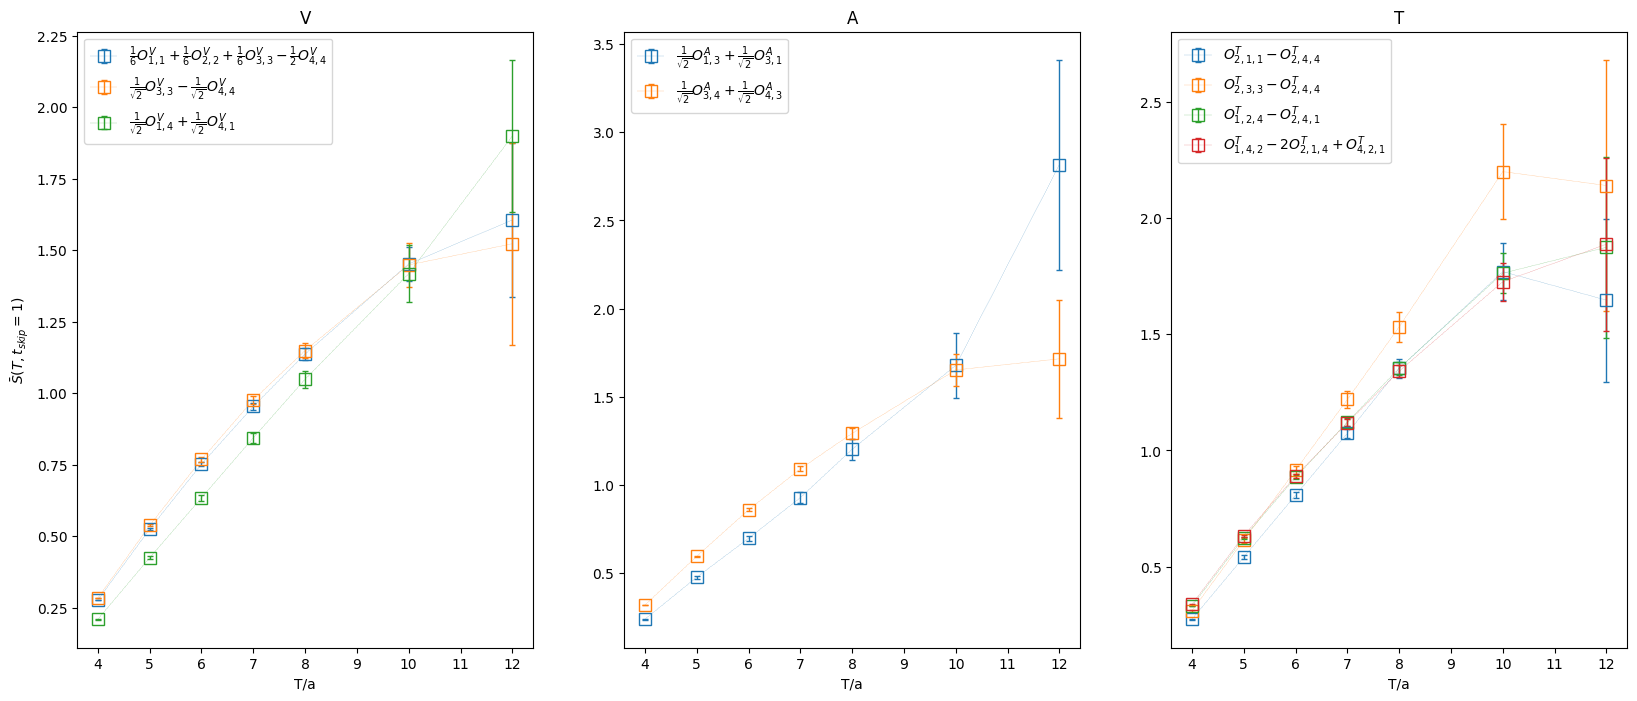

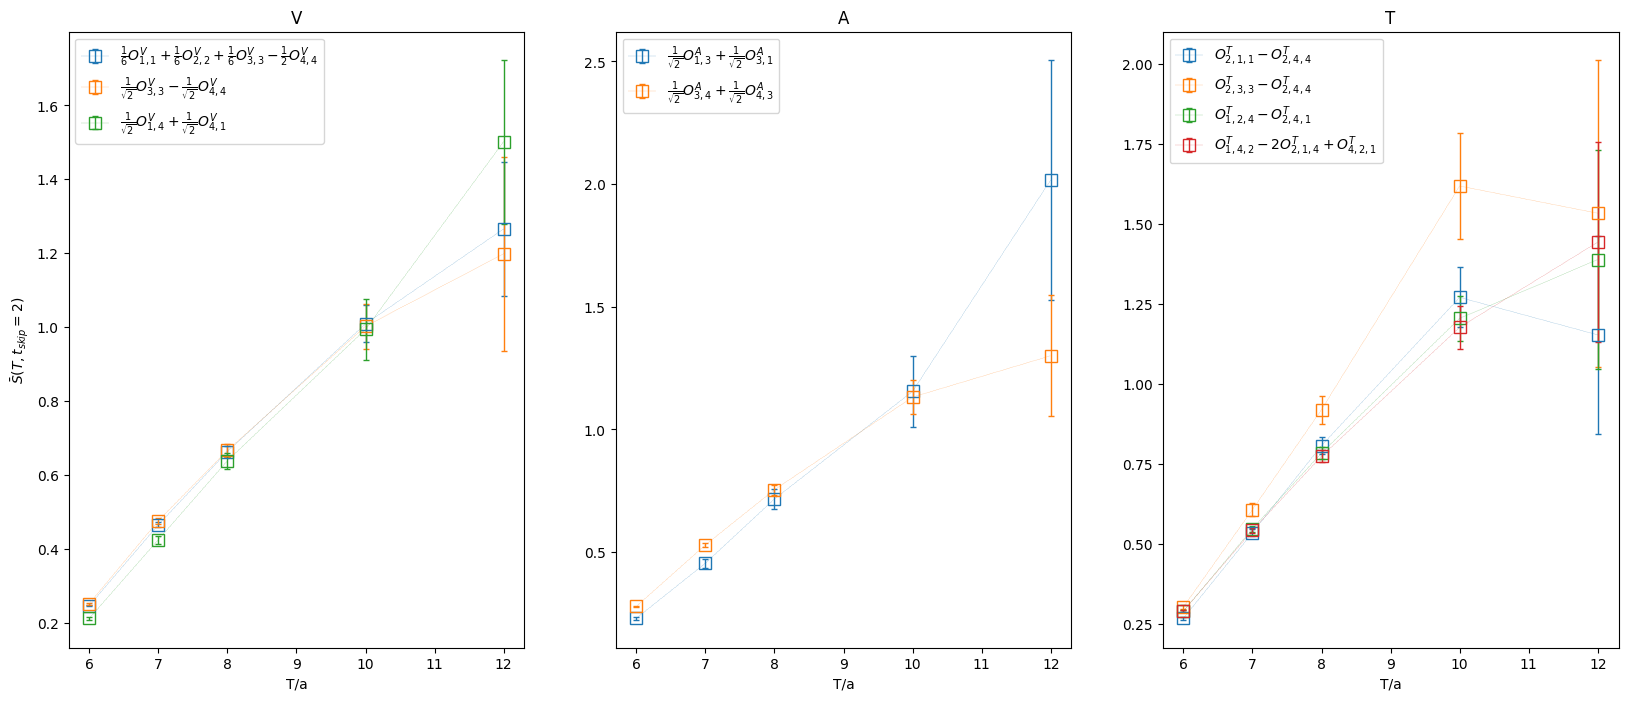

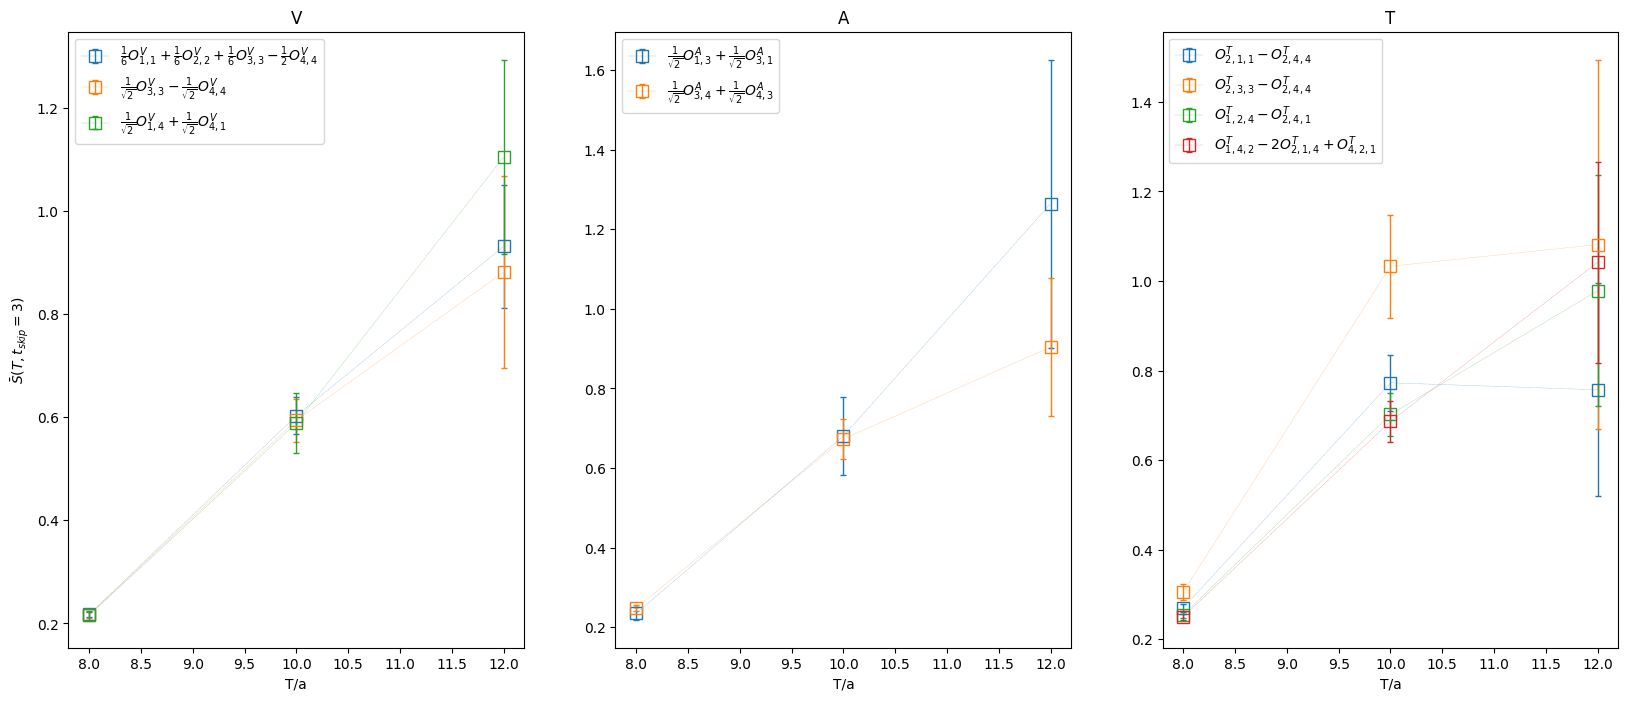

In [5]:
_ = opAnalyzer.plot_S(tskip=1, save=True)
_ = opAnalyzer.plot_S(tskip=2, )
_ = opAnalyzer.plot_S(tskip=3, )

# One Operator Analysis

## Fix iop

In [6]:
#we do the analysis first for one operator
iop = 0

## Matrix Element from Finite Differences

In [7]:
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

#we fix the input
tskip_list = [1,2]
delta_list = [1,2,3]
T_list = opAnalyzer.chosen_T_list[:]


E0 = opAnalyzer.get_E()
m = opAnalyzer.get_m()
p1,p2,p3 = opAnalyzer.get_P()

kin = opAnalyzer.selected_op[iop].evaluate_K_gvar(m_value=m, E_value=E0, p1_value=p1,p2_value=p2,p3_value=p3)

In [8]:


p3_corr = p3corr[iop]
p2_corr = p2corr[:]

#we start by instantiatinh the list with the summed ratios we are going to use, shape = (NT, Ntskip)
S_list = np.zeros(shape=(len(T_list), len(tskip_list)),  dtype=float)

#loop over selected tau skip
for i_tskip, tskip in enumerate(tskip_list):

    #loop over available source sink seprations T
    for iT , T in enumerate(T_list):

        #we compute the summed ratio with the formula
        S_list[iT,i_tskip] = sum_ratios_formula( ratio_formula(p3_corr[:,iT,:], p2_corr, T=T, gauge_axis=0), T, tskip, time_axis=-1)

S_list / kin.mean

array([[0.        , 0.        ],
       [0.27754378, 0.        ],
       [0.52538678, 0.        ],
       [0.75227541, 0.24698057],
       [0.95346299, 0.46544742],
       [1.13644286, 0.66294082],
       [1.45294599, 1.00921479],
       [1.6198176 , 1.27282093]])

In [9]:
#we instantiate the list with the allowed matrix elements as empty
mat_ele_array = np.zeros(shape=(len(T_list),len(tskip_list),len(delta_list)), dtype=float) #shape = (nT,)


#we loop over the source-sink separations T, from the cut on
for iT, T in enumerate(T_list):

    #we loop over the values of tau skip
    for itskip,tskip in enumerate(tskip_list):

        if np.abs( S_list[iT,itskip] ) < 10**(-18): continue

        #we loopv over the delta we want to use in the analysis (delta is the separation we use to look at the slope)
        for idelta, delta in enumerate(delta_list):
            
            #a combination T,delta is allowed only if their sum is in the available Ts
            if T + delta in T_list:

                #we check what is the index of the T we have to consider
                iT_plus_delta = T_list.index(T + delta)

                #we compute the matrix element as the slope of the summed ratio function    
                mat_ele_array[iT,itskip,idelta] = (S_list[iT_plus_delta,itskip] - S_list[iT,itskip])/delta

mat_ele_array

mat_ele_mean = np.sum(mat_ele_array) / np.count_nonzero(mat_ele_array)
mean2 =  np.sum(mat_ele_array**2) / np.count_nonzero(mat_ele_array)

mat_ele_std = np.sqrt(mean2 - mat_ele_mean**2) /np.sqrt( np.count_nonzero(mat_ele_array) )

mat_ele = gv.gvar(mat_ele_mean,mat_ele_std)
mat_ele

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.08147139, 0.07802731, 0.07406312],
        [0.        , 0.        , 0.        ]],

       [[0.07458324, 0.07035899, 0.06695581],
        [0.        , 0.        , 0.        ]],

       [[0.06613474, 0.0631421 , 0.        ],
        [0.07181481, 0.0683676 , 0.        ]],

       [[0.06014947, 0.        , 0.05473031],
        [0.06492038, 0.        , 0.05958273]],

       [[0.        , 0.05202074, 0.        ],
        [0.        , 0.0569139 , 0.        ]],

       [[0.        , 0.02742716, 0.        ],
        [0.        , 0.04332654, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

0.0630(30)

In [10]:


mom = mat_ele / kin
mom

0.1916(92)

### plot

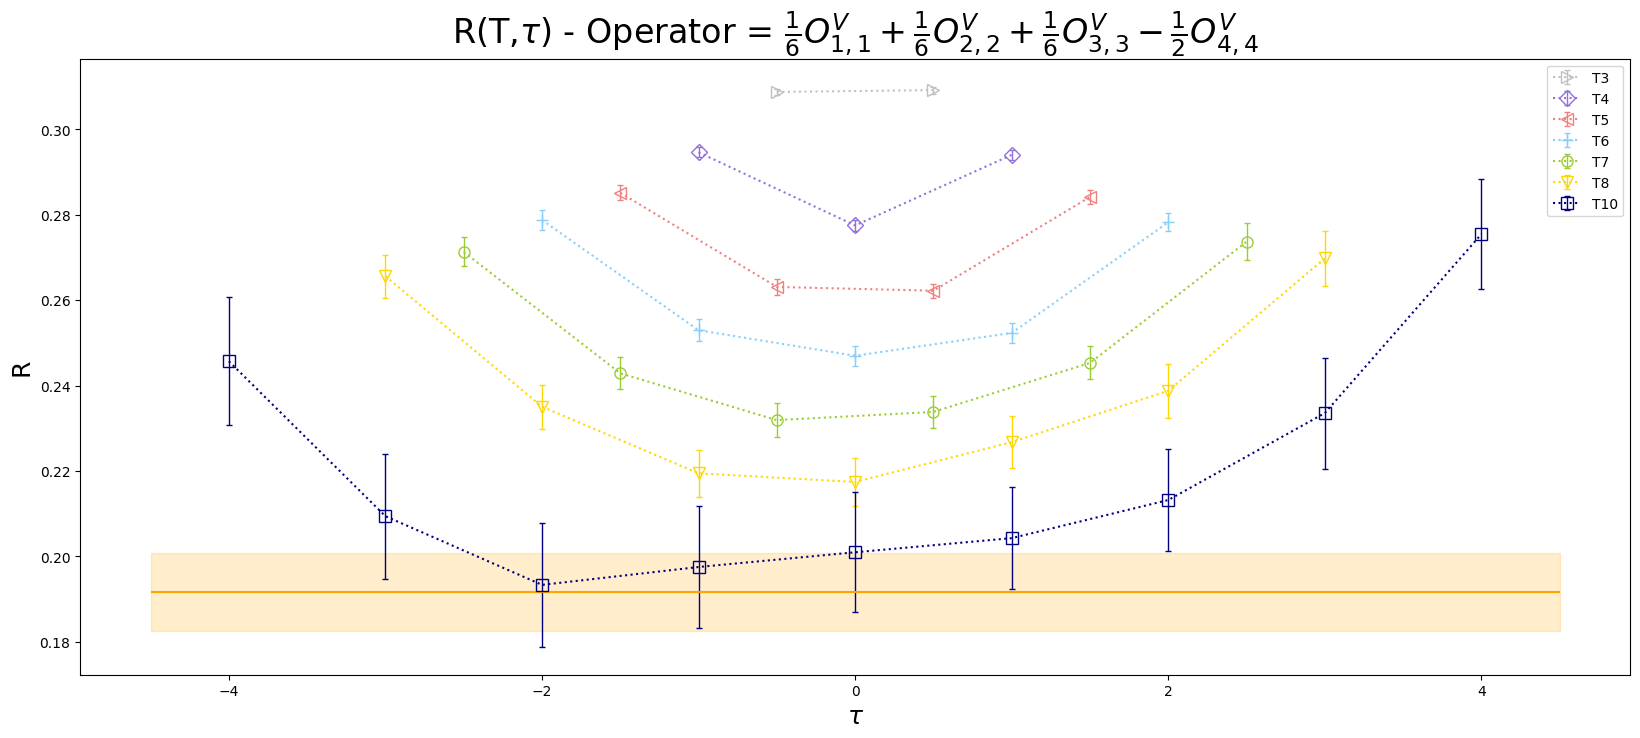

In [11]:
opAnalyzer.remove_T(12,16,verbose=False)
fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)

fig, ax = fig_ax_list[opAnalyzer.selected_op[iop].O]

Tmax = 11

_ = ax.hlines(mom.mean,-Tmax/2+1,Tmax/2-1,linestyle="solid", color="orange")

_ = ax.fill_between(np.arange(-Tmax/2+1,Tmax/2), mom.mean - mom.sdev, mom.mean + mom.sdev, alpha=0.2, color="orange")

for jop in range(opAnalyzer.Nop):
    if jop!=iop:
        plt.close(fig_ax_list[opAnalyzer.selected_op[jop].O][0])
plt.show()
opAnalyzer.remove_T()

## Matrix Element from Fit

In [12]:
tskip=1
Smean, Sstd = opAnalyzer.get_S(tskip=tskip)

#the treshold value that should be removed is
T_treshold = 1 + 2*tskip #because we want to have (T+1) -2 -2tau_skip > 0

#we instantiate the times T to plot to the full list
T_plot = opAnalyzer.chosen_T_list[:]

if T_treshold < opAnalyzer.chosen_T_list[0]:
    iT_cut = 0
    T_plot = opAnalyzer.chosen_T_list[iT_cut:]
    Smean = Smean[iop,iT_cut:]
    Sstd = Sstd[iop,iT_cut:]
else:


    #we loop over all the smaller values of T to find the one from which we should start cutting the data
    for T in range(T_treshold, opAnalyzer.chosen_T_list[0]-1,-1):
        "ok"

        #when (and if) we find the biggest value that can be removed, we remove from it onward and stop the loop
        if T in opAnalyzer.chosen_T_list:

            #the index from where we will cut is
            iT_cut = opAnalyzer.chosen_T_list.index(T) + 1

            #we cut the relevant arrays (the x and y of the plots)
            T_plot = opAnalyzer.chosen_T_list[iT_cut:]
            Smean = Smean[iop,iT_cut:]
            Sstd = Sstd[iop,iT_cut:]

            #we stop the loop if we find one of such values
            break

T_plot
Smean
Sstd

'ok'

[4, 5, 6, 7, 8, 10, 12]

array([0.09122288, 0.17268403, 0.24728587, 0.31357459, 0.3739026 ,
       0.47736886, 0.52796813])

array([0.00040423, 0.00105617, 0.00206183, 0.00417575, 0.00721117,
       0.01950839, 0.08815008])

In [13]:
prior = gv.BufferDict()


slope_mean = (Smean[-1] - Smean[0]) / (T_plot[-1] - T_plot[0])
intercept_mean = Smean[0] - slope_mean * T_plot[0]

prior["m"] = gv.gvar(slope_mean,slope_mean)
prior["q"] = gv.gvar(intercept_mean,intercept_mean)

prior

BufferDict({'m': 0.055(55), 'q': -0.13(13)})

In [14]:
def lin_func(x,p):
    return p["m"]*x+p["q"]

In [15]:
Smean

T_plot

array([0.09122288, 0.17268403, 0.24728587, 0.31357459, 0.3739026 ,
       0.47736886, 0.52796813])

[4, 5, 6, 7, 8, 10, 12]

In [16]:
#we do the fit
fit_result = CA.fit(

    abscissa                = np.asarray(T_plot),
    
    ordinate_est            = Smean, 
    ordinate_std            =  Sstd, 
    ordinate_cov            =   None, 
    
    resample_ordinate_est   = None,
    resample_ordinate_std   = None, 
    resample_ordinate_cov   = None,

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = False,

    resample_fit                 = False,
    resample_fit_correlated      = False,
    
    resample_fit_resample_prior  = False,
    resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected

    # args for lsqfit:
    model   = lin_func,
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

# fit_result_lin = CA.linear_regression(

#     abscissa                = np.asarray(T_plot),
    
#     ordinate_est            = Smean, 
#     ordinate_std            =  Sstd, 
#     ordinate_cov            =   None, 
    
#     resample_ordinate_est   = None,
#     resample_ordinate_std   = None, 
#     resample_ordinate_cov   = None,

#     # fit strategy, default: only uncorrelated central value fit:
#     central_value_fit            = True,
#     central_value_fit_correlated = False,

#     resample_fit                 = False,
#     resample_fit_correlated      = False,
    
#     resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected

#     # args for lsqfit:
#     has_intercept=True,
#     parameter_names=["m","q"]
# )

In [17]:
fit_result

fit_result.best_fit_param["m"] / kin

FitResult[ (4,12), resample:False]:
  𝜒²/dof [dof] = 7.68 [7]
  AIC = 46.8 
    - m: 0.07675(65)  [0.055(55)]
    - q: -0.2153(27)  [-0.13(13)]

0.2335(25)

In [18]:
Zfact = gv.gvar(1.0736,0.0202) * gv.gvar(0.9094,0.0036)
Zfact

fit_result.best_fit_param["m"] / kin * Zfact

0.976(19)

0.2279(50)

In [19]:
fit_result

fit_result.best_fit_param["m"] / kin

FitResult[ (4,12), resample:False]:
  𝜒²/dof [dof] = 7.68 [7]
  AIC = 46.8 
    - m: 0.07675(65)  [0.055(55)]
    - q: -0.2153(27)  [-0.13(13)]

0.2335(25)

<ErrorbarContainer object of 3 artists>

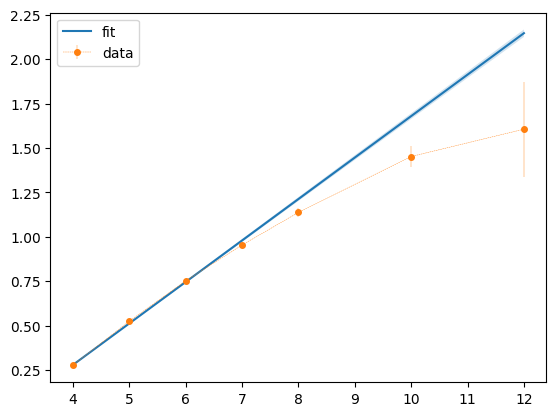

In [20]:
abscissa = np.arange(fit_result.ts, fit_result.te+1)
ordinate = fit_result.eval(abscissa) 

ordinate = gv.gvar(ordinate["est"],ordinate["err"]) / kin

ordinate_data = gv.gvar(Smean,Sstd) / kin

plt.plot( abscissa, [o.mean for o in ordinate],
                      linestyle="-",label="fit")

plt.fill_between(abscissa, [o.mean + o.sdev for o in ordinate] ,  [o.mean - o.sdev for o in ordinate] , alpha= 0.2,)

plt.errorbar(T_plot, [e.mean for e in ordinate_data], yerr=[e.sdev for e in ordinate_data], marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label="data")
plt.legend()

In [21]:
np.arange(fit_result.ts, fit_result.te+1)
T_plot

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])

[4, 5, 6, 7, 8, 10, 12]

In [22]:
ordinate_tmp = fit_result.eval(np.asarray(T_plot))
ordinate_fit = gv.gvar(ordinate_tmp["est"],ordinate_tmp["err"]) / kin

res = ordinate_fit -ordinate_data
res

array([0.0015(17), -0.0128(37), -0.0063(73), 0.026(14), 0.075(23),
       0.228(60), 0.54(27)], dtype=object)

<ErrorbarContainer object of 3 artists>

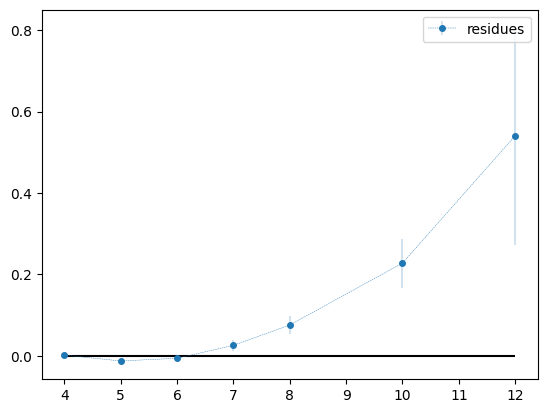

In [23]:

plt.errorbar(T_plot, [e.mean for e in res], yerr=[e.sdev for e in res], marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label="residues")

plt.hlines(0,xmin=min(T_plot), xmax=max(T_plot),color="black")

plt.legend()

In [24]:
data_nd = opAnalyzer.get_p3corr()
data_nd.shape

n_resamples = 99

nconf = data_nd.shape[1]

np.take(data_nd, np.random.randint(nconf, size=nconf*n_resamples), axis=1 ).reshape(n_resamples, *data_nd.shape).shape

(9, 212, 8, 13)

(99, 9, 212, 8, 13)

In [25]:
bts_resamples = np.take(data_nd, np.random.randint(nconf, size=nconf*n_resamples), axis=1 ).reshape(n_resamples, *data_nd.shape)

bts_mean = bts_resamples.mean(axis=0)
bts_std = bts_resamples.std(axis=0) / np.sqrt(n_resamples-1)

#bts_cov = np.cov(bts_resamples)
bts_mean

array([[[[-2.53452338e-14,  5.73455536e-14,  5.69200329e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.27780558e-14,  2.72233509e-14,  2.43677395e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.59341084e-15,  1.33497047e-14,  1.14392650e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.10735915e-15,  1.48843402e-15,  9.68319469e-16, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-5.40960390e-17,  4.05518594e-16,  1.54700907e-16, ...,
           3.51150968e-17,  0.00000000e+00,  0.00000000e+00],
         [ 3.58775447e-17,  2.44454258e-16,  9.67926492e-17, ...,
           3.19824391e-16,  3.65899977e-16,  4.90687663e-18]],

        [[-2.60703367e-14,  5.57275103e-14,  5.53748457e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.34472632e-14,  2.61828147e-14,  2.32365716e-14, ...,
           0.00000000e

In [26]:
np.random.randint(10,size=5)

array([2, 6, 3, 4, 3])

In [27]:
data_nd = opAnalyzer.get_p3corr()[0]
data_nd.shape

n_resamples = 99
data_nd[np.random.randint(len(data_nd), size=len(data_nd)*n_resamples)].reshape(n_resamples, *data_nd.shape).shape

(212, 8, 13)

(99, 212, 8, 13)

# Systematic Comparison

Finite differences

$$\mathcal{M} (T) = AVG_{\delta,\tau_{skip}} \left[ \frac{S(T+\delta,\tau_{skip}) - S(T,\tau_{skip})}{\delta} \right]$$

Fit

$$\mathcal{M} (T) = AVG_{\tau_{skip}} \left[ SlopeFromFit\left( T_{min}=T, S(:, \tau_{skip}) \right) \right]$$


In [28]:
tskip_list = [1,2,3] if True else [1]
delta_list = [1,2,3] if True else [1,2]

Klist = opAnalyzer.get_Klist()

opAnalyzer.chosen_T_list

[3, 4, 5, 6, 7, 8, 10, 12]

## Finite differences

In [29]:
from moments_toolkit import jackknife,MatEle_from_slope_formula

In [30]:
#we first take the correlators we need to compute everything
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

#we instantiate the output array
mat_ele_array = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)
moments_array = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)


#we fill the output array using the formula for the matrix element from S
for iop in range(opAnalyzer.Nop):

    #we compute mean and std of the matrix element using the jackknife
    mat_ele, mat_ele_std, _ = jackknife([p3corr[iop],p2corr], observable = lambda x,y: MatEle_from_slope_formula(p3_corr=x, p2_corr=y, T_list=opAnalyzer.chosen_T_list, delta_list=delta_list, tskip_list=tskip_list), res_axis_list=[0,0], time_axis=None)

    #we put them into a gvar variable and store it into the array
    mat_ele_array[iop] = gv.gvar(mat_ele,mat_ele_std)
    moments_array[iop] = gv.gvar(mat_ele,mat_ele_std) / Klist[iop]

In [31]:
mat_ele_array
moments_array

array([[0 ± 0, 0.07785(94), 0.0706(18), 0.0673(25), 0.0598(41),
        0.0573(68), 0.039(33), 0 ± 0],
       [0 ± 0, 0.1062(15), 0.0954(28), 0.0908(38), 0.0760(66), 0.074(11),
        0.039(62), 0 ± 0],
       [0 ± 0, -0.0788(15), -0.0774(28), -0.0779(37), -0.0736(73),
        -0.067(13), -0.092(34), 0 ± 0],
       [0 ± 0, 0.0390(12), 0.0384(22), 0.0398(31), 0.0426(66), 0.038(10),
        0.071(34), 0 ± 0],
       [0 ± 0, -0.1066(13), -0.0984(25), -0.0930(37), -0.0808(74),
        -0.077(11), -0.031(47), 0 ± 0],
       [0 ± 0, -0.1395(25), -0.1400(47), -0.1407(65), -0.134(13),
        -0.120(21), 0.025(67), 0 ± 0],
       [0 ± 0, -0.0791(21), -0.0793(40), -0.0801(56), -0.084(10),
        -0.090(19), 0.006(55), 0 ± 0],
       [0 ± 0, 0.2031(28), 0.1829(49), 0.1787(66), 0.165(13), 0.156(22),
        0.07(12), 0 ± 0],
       [0 ± 0, 0.3737(46), 0.3309(82), 0.320(11), 0.293(23), 0.276(37),
        0.17(20), 0 ± 0]], dtype=object)

array([[0 ± 0, 0.2368(33), 0.2148(56), 0.2049(77), 0.182(13), 0.174(21),
        0.12(10), 0 ± 0],
       [0 ± 0, 0.2420(39), 0.2174(67), 0.2069(88), 0.173(15), 0.169(25),
        0.09(14), 0 ± 0],
       [0 ± 0, 0.2128(42), 0.2089(74), 0.211(10), 0.199(20), 0.181(36),
        0.248(92), 0 ± 0],
       [0 ± 0, 0.2322(72), 0.229(13), 0.237(18), 0.254(39), 0.225(62),
        0.42(20), 0 ± 0],
       [0 ± 0, 0.2678(41), 0.2472(67), 0.2337(95), 0.203(19), 0.194(28),
        0.08(12), 0 ± 0],
       [0 ± 0, 0.2665(48), 0.2674(90), 0.269(12), 0.256(24), 0.229(41),
        -0.05(13), 0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.306(22), 0.320(40), 0.345(74),
        -0.02(21), 0 ± 0],
       [0 ± 0, 0.2779(41), 0.2502(68), 0.2445(91), 0.225(17), 0.213(29),
        0.09(17), 0 ± 0],
       [0 ± 0, 0.2765(38), 0.2448(63), 0.2369(86), 0.217(17), 0.204(28),
        0.13(15), 0 ± 0]], dtype=object)

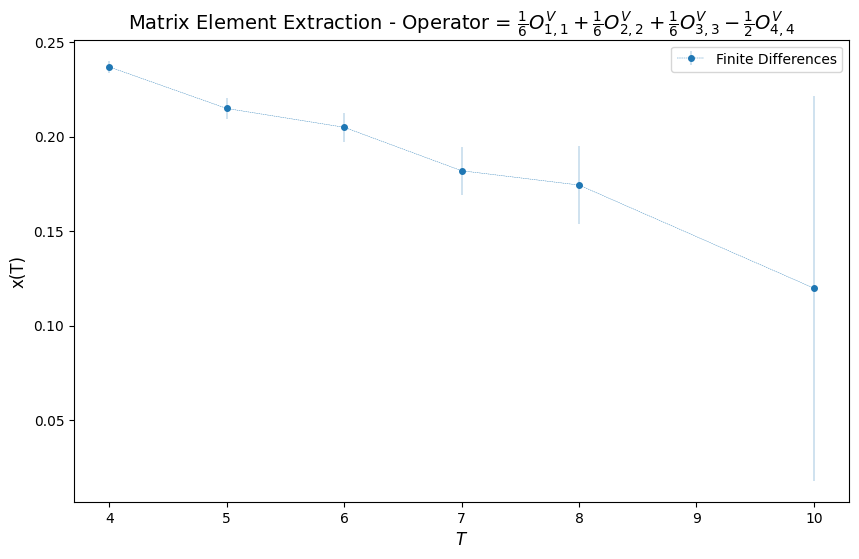

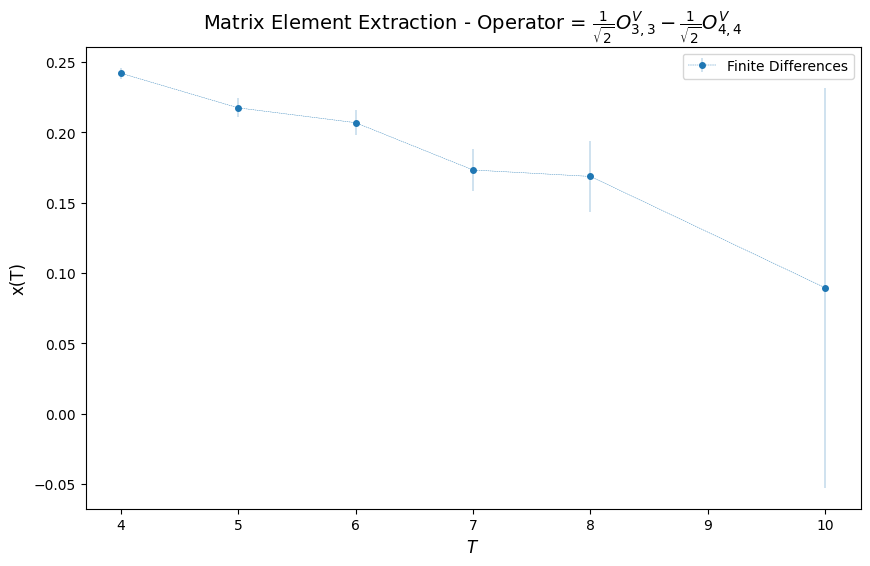

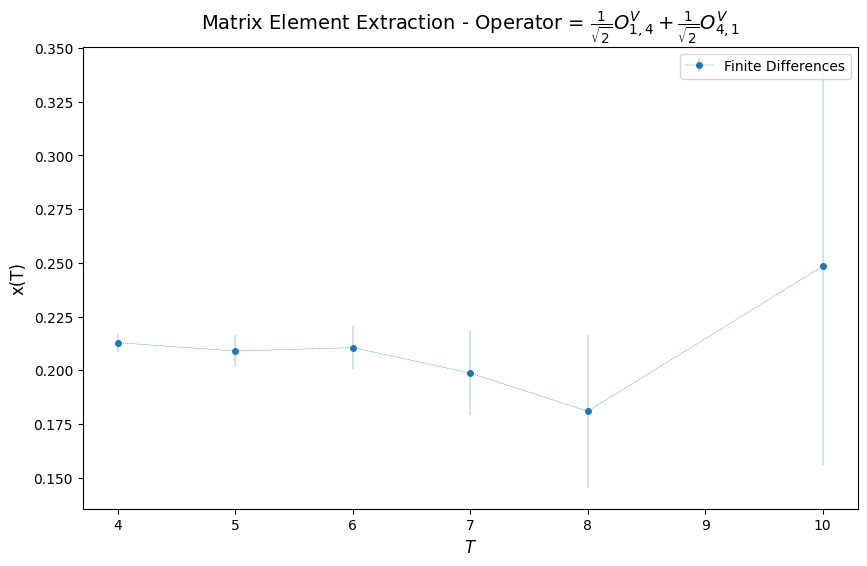

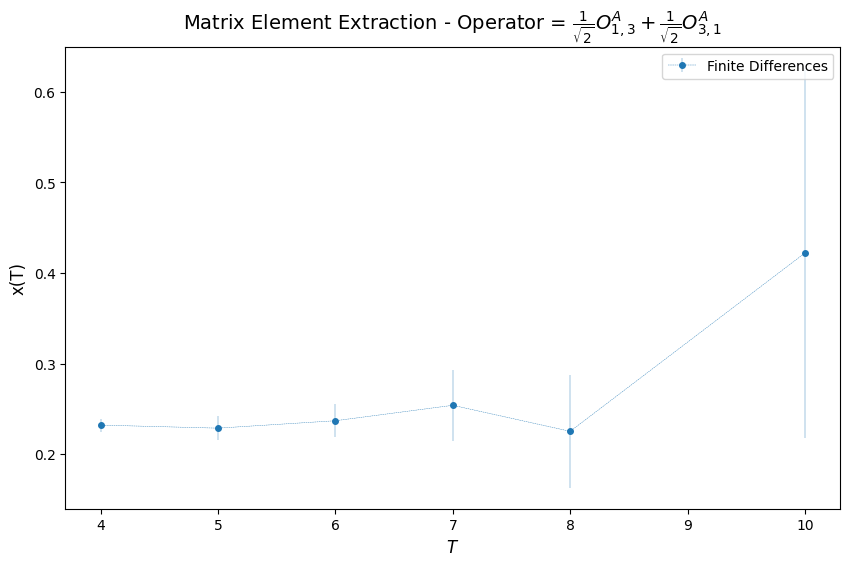

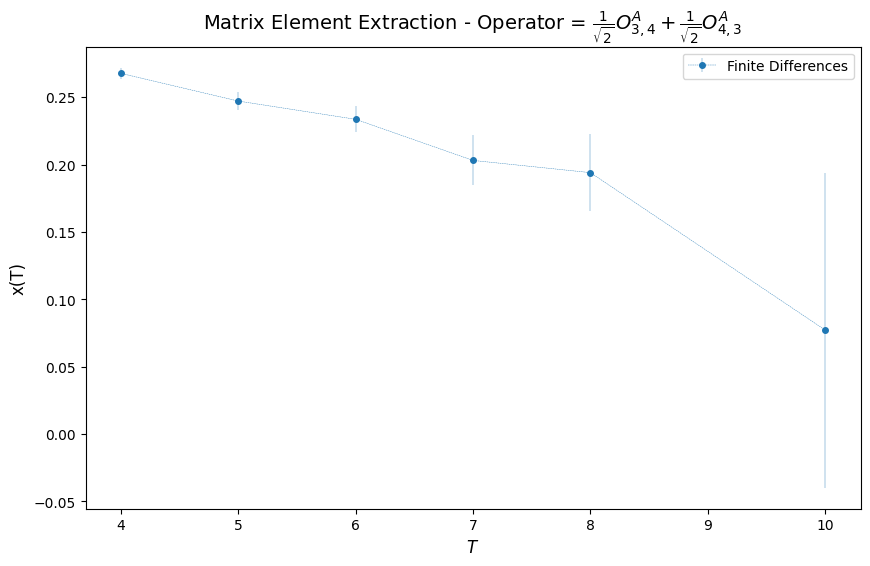

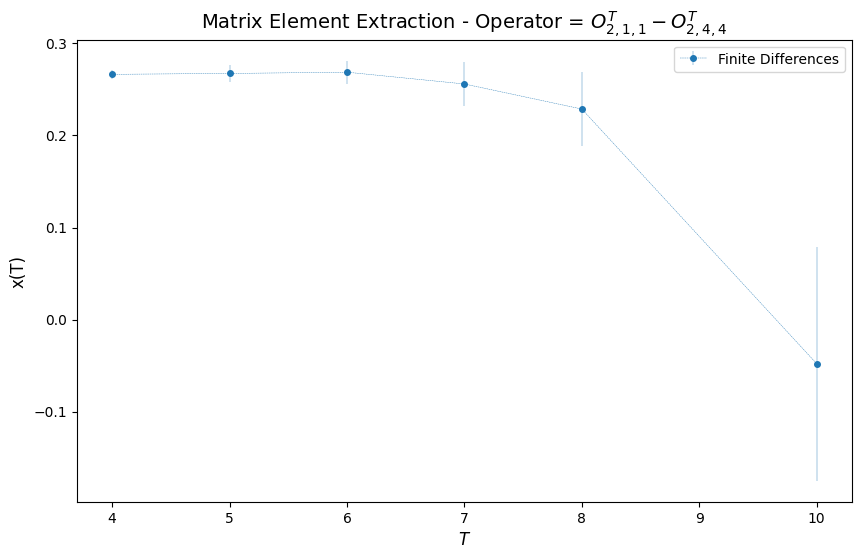

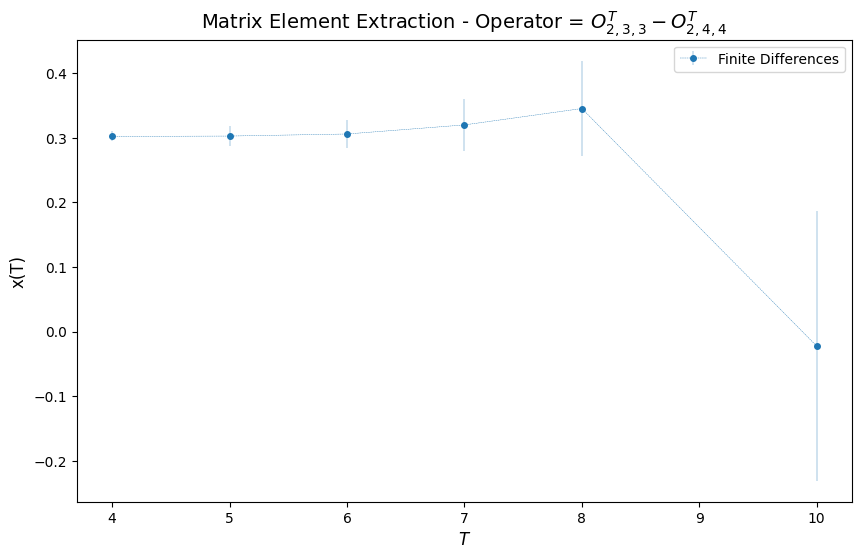

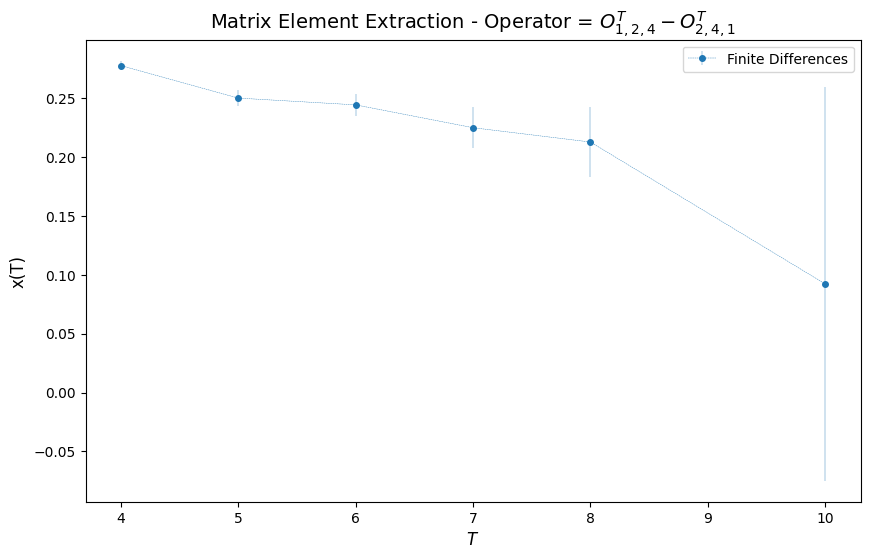

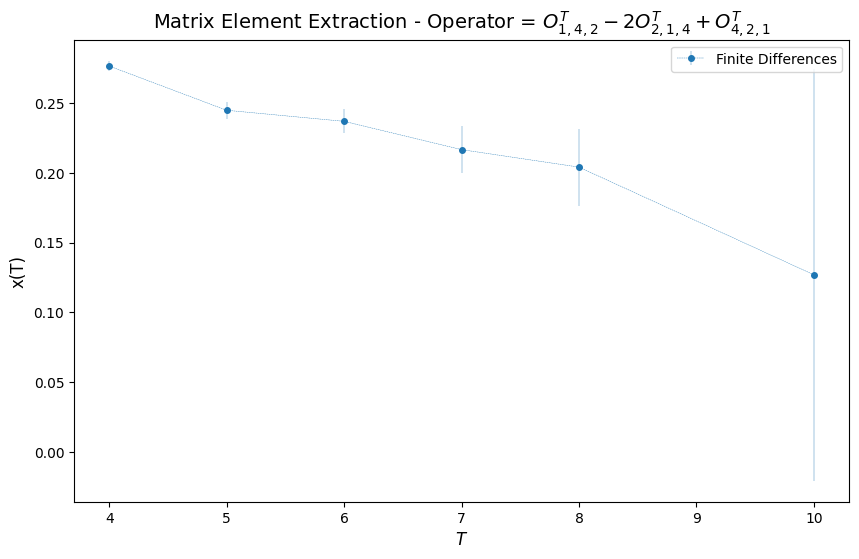

In [32]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    ordinate_array = moments_array if moments else mat_ele_array
    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    asc = [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array[iop][i].mean)>10**(-18)]
    ord = [e.mean for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]
    ord_sig = [e.sdev for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label=f"Finite Differences")

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

## Fit

In [33]:
#we fetch the summed ratios
Smean_array = np.zeros(shape=(len(tskip_list),opAnalyzer.Nop,opAnalyzer.nT))
Sstd_array = np.zeros(shape=(len(tskip_list),opAnalyzer.Nop,opAnalyzer.nT))
for itskip,tskip in enumerate(tskip_list):
    Smean, Sstd = opAnalyzer.get_S(tskip=tskip)
    Smean_array[itskip] = Smean
    Sstd_array[itskip] = Sstd

In [34]:
def lin_func(x,p):
    return p["m"]*x+p["q"]

In [35]:
mat_ele_array_fit = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)
moments_array_fit = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)


#loop over different operators
for iop,op in enumerate(opAnalyzer.selected_op):

    #loop over starting times
    for iTstart, Tstart in enumerate(opAnalyzer.chosen_T_list):

        #for each tuple (operator,starting time) we instantiate a fit state
        fit_state = CA.FitState()

        ## we want to average over various fit changing the value of tskip and that of the last time considered 

        for itskip,tskip in enumerate(tskip_list):

            #we skip the value of tskip that are not allowed
            if tskip >= (Tstart-1)/2: continue

            #we loop over the maximum time considered
            for iTend,Tend in enumerate(opAnalyzer.chosen_T_list):

                #we skip all the endtimes that are smaller (by 2) w.r.t. the start time
                if iTend-iTstart < 3: continue

                #we determine the fit abscissa and ordinate
                abscissa = np.asarray( opAnalyzer.chosen_T_list[iTstart:iTend+1] )
                #if iop==0: print(abscissa)
                ordinate = Smean_array[itskip,iop,iTstart:iTend+1]
                ordinate_err = Sstd_array[itskip,iop,iTstart:iTend+1]

                #we determine the prior
                prior = gv.BufferDict()

                slope = (ordinate[-1] - ordinate[0]) / (abscissa[-1] - abscissa[0])
                intercept = ordinate[0] - slope * abscissa[0]

                prior["m"] = gv.gvar(slope,slope) #100% error
                prior["q"] = gv.gvar(intercept,intercept)

                #if iop==0: f"performing the fit for Tstart {Tstart}, tskip {tskip}, Tend {Tend} (len abscissa = {len(abscissa)}) "

                #we do the fit
                fit_result = CA.fit(

                    abscissa                = abscissa,
                    
                    ordinate_est            = ordinate, 
                    ordinate_std            =  ordinate_err, 
                    ordinate_cov            =   None, 
                    
                    resample_ordinate_est   = None,
                    resample_ordinate_std   = None, 
                    resample_ordinate_cov   = None,

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected

                    # args for lsqfit:
                    model   = lin_func,
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
                )

                #if iop==0: f"Nparam = {len(fit_result.best_fit_param.keys())}, Ndata = {fit_result.Ndata}, te = {fit_result.te}, ts = {fit_result.ts}"

                #we append the fit result to the fit state
                fit_state.append(fit_result)


        

        mat_ele_array_fit[iop,iTstart] = gv.gvar(fit_state.model_average()["est"]["m"],fit_state.model_average()["err"]["m"]) if len(fit_state.model_average())>0 else gv.gvar(0,0)
        moments_array_fit[iop,iTstart] = mat_ele_array_fit[iop,iTstart] / Klist[iop]

        


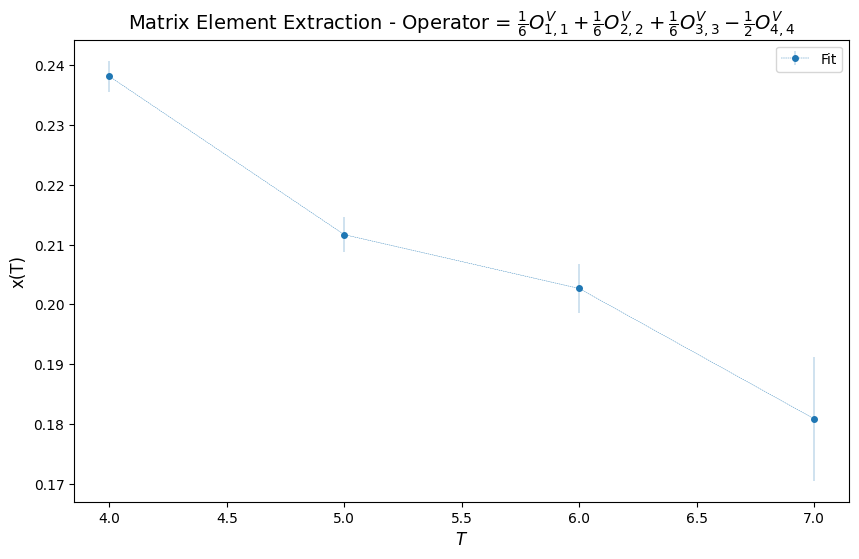

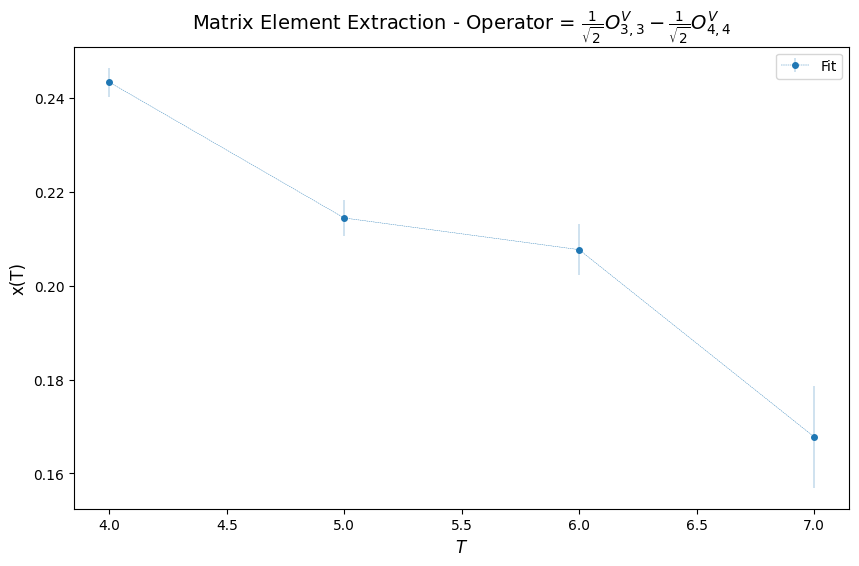

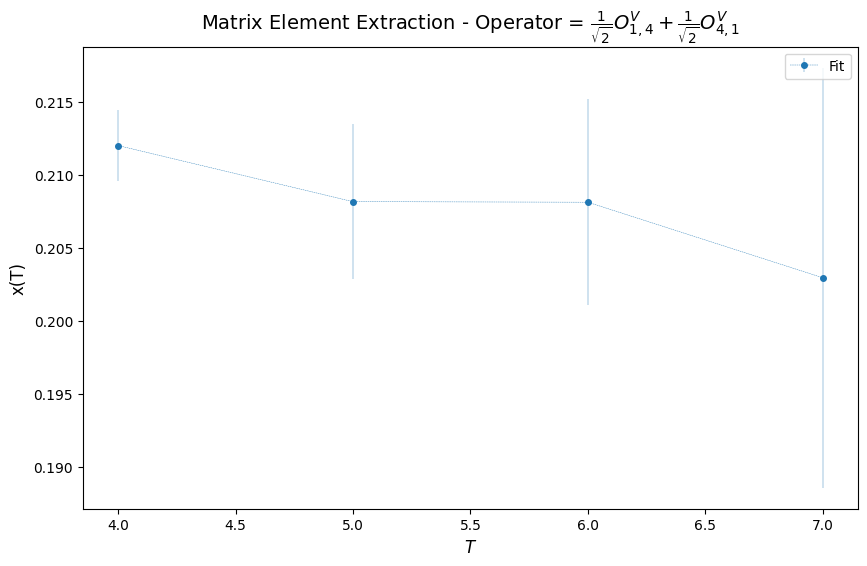

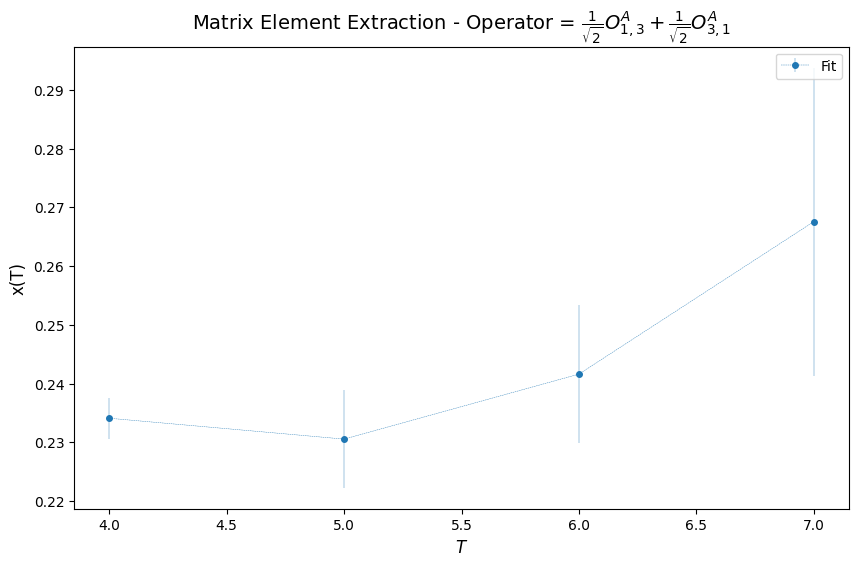

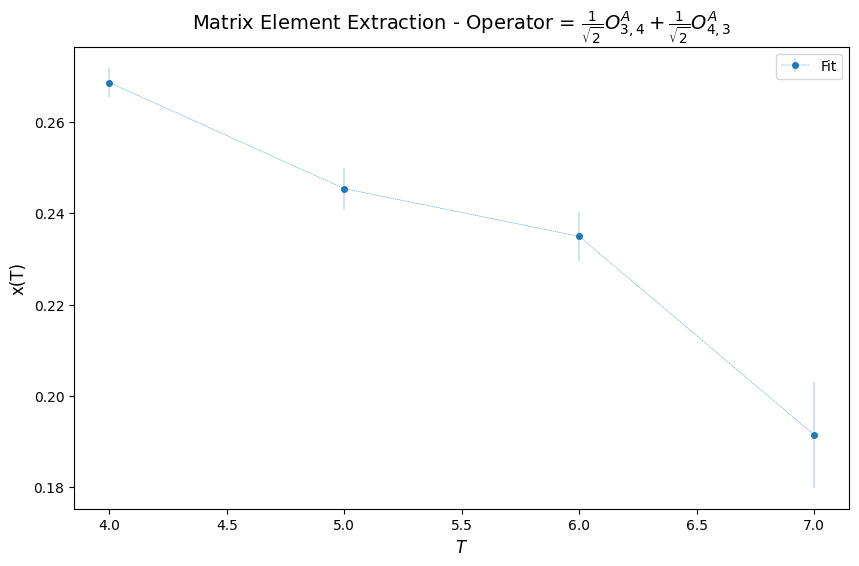

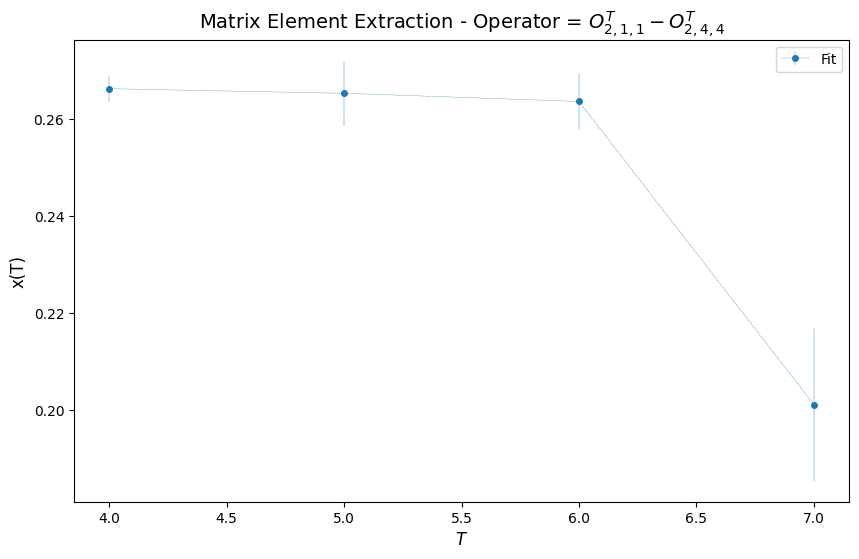

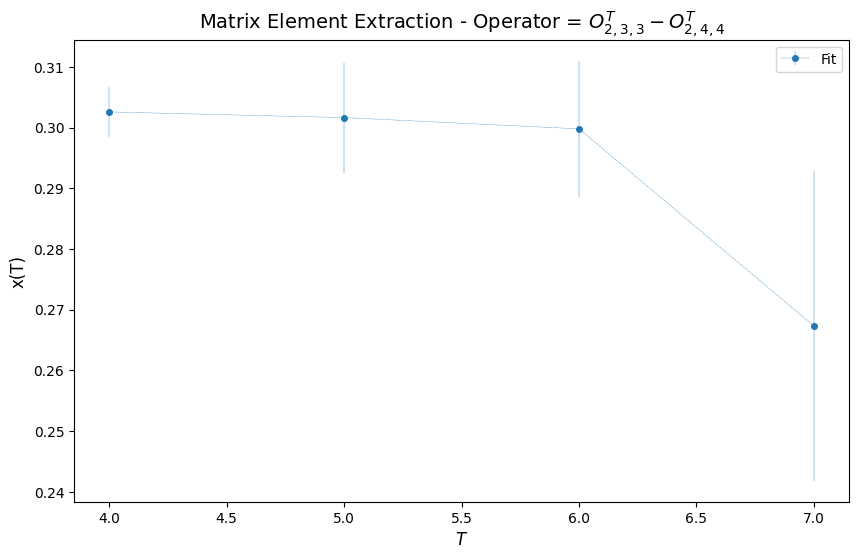

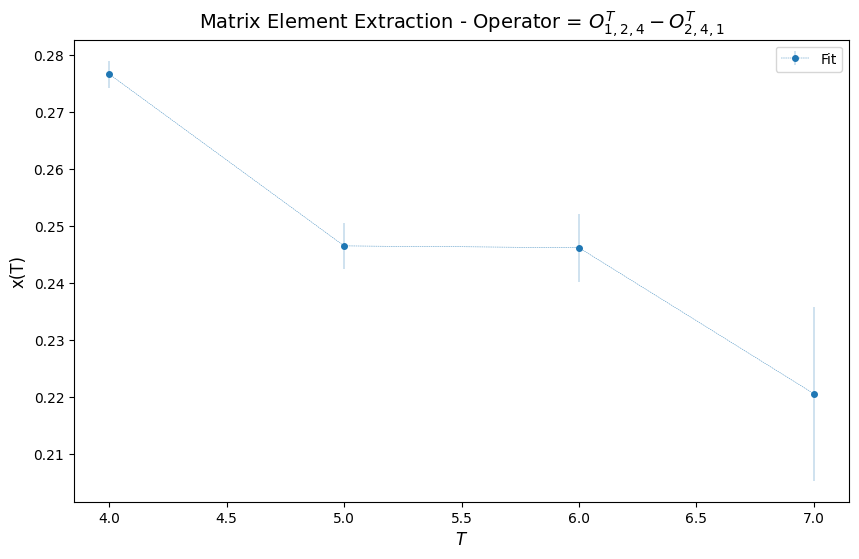

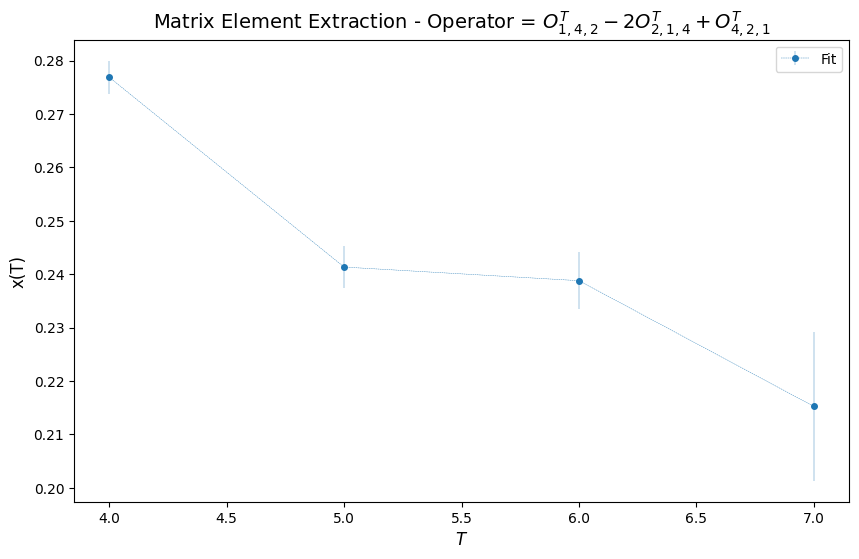

In [36]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    ordinate_array = moments_array_fit if moments else mat_ele_array_fit
    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    asc = [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array[iop][i].mean)>10**(-18)]
    ord = [e.mean for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]
    ord_sig = [e.sdev for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label=f"Fit")

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

## Comparison

In [37]:
#opAnalyzer.set_resampling_type('bootstrap',Nres=1000)
opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.set_fit_parms(central_value_fit=True,central_value_fit_correlated=True,resample_fit=True,resample_fit_correlated=True)

opAnalyzer

#usage of the new method
moments_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=True, tskip_list=[1,2,3])
mat_ele_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=False, tskip_list=[1,2,3])
moments_array = opAnalyzer.get_M_from_S(method="finite differences",moments=True, tskip_list=[1,2,3],delta_list=[1,2,3])
mat_ele_array = opAnalyzer.get_M_from_S(method="finite differences",moments=False, tskip_list=[1,2,3],delta_list=[1,2,3])

from moments_toolkit import average_moments_over_T

Instance of the moments_toolkit class

Dataset Specifics:
Number of configurations: 212
P: [-2  0  0]
q: [0 0 0]

Current Selection of Parameters:
Number of Selected Operators: 9
Selected Isospin: U-D
Selected T values: [3, 4, 5, 6, 7, 8, 10, 12]

Fit parameters:
 - Central Value Fit:            True
 - Central Value Fit Correlated: True
 - Resample Fit:                 True
 - Resample Fit Correlated:      True
 - Resample Fit Resample Prior:  False
 - SVD Cut: None
 - Max Iterations: 10000

Resampling Technique: bootstrap
Number of resamples: 424

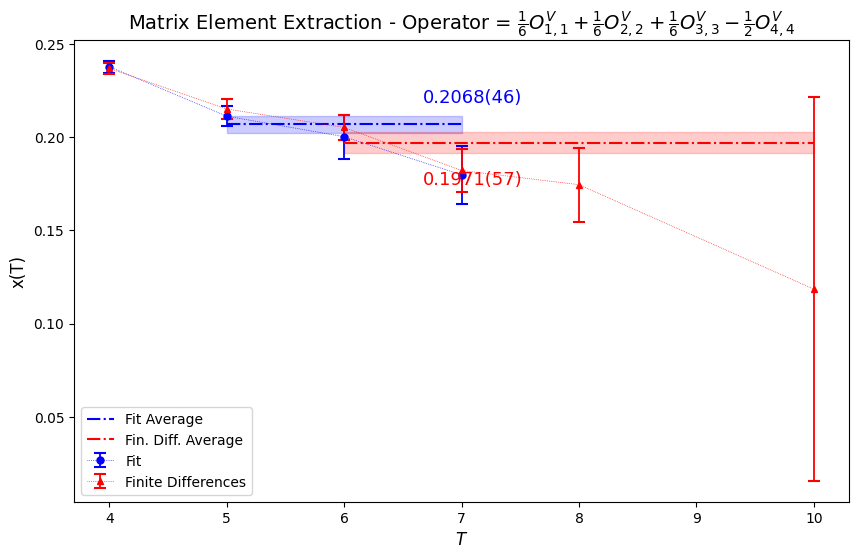

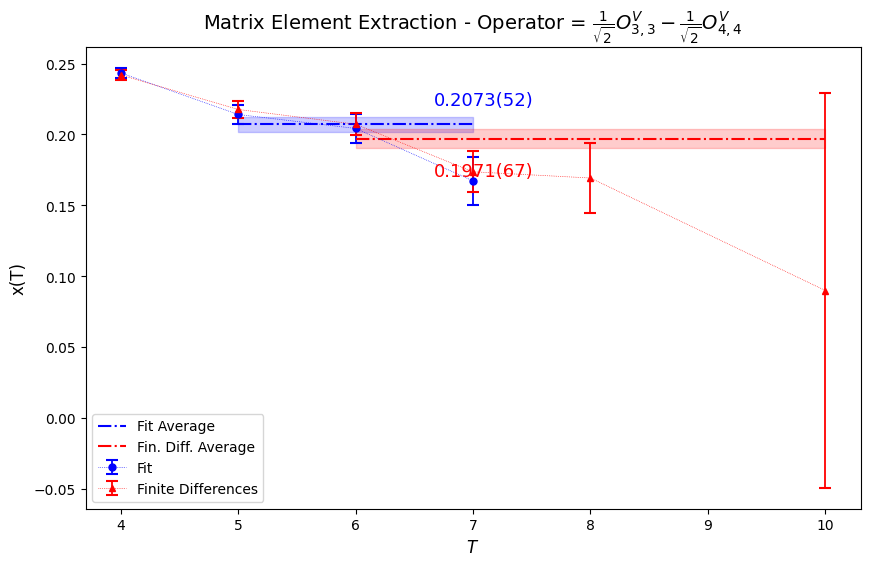

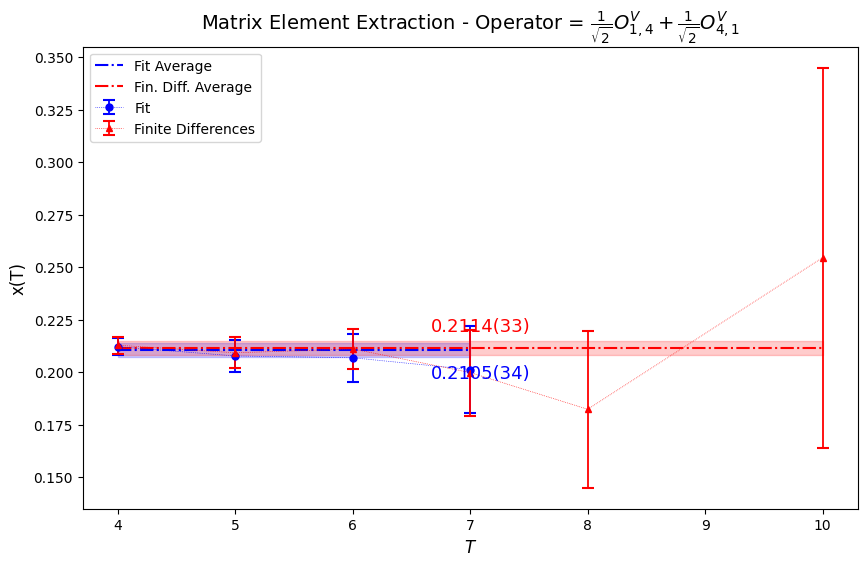

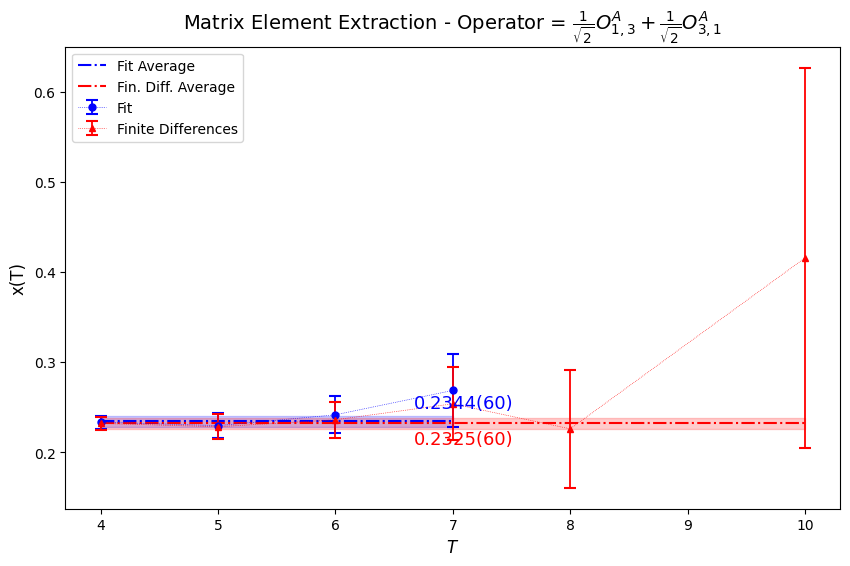

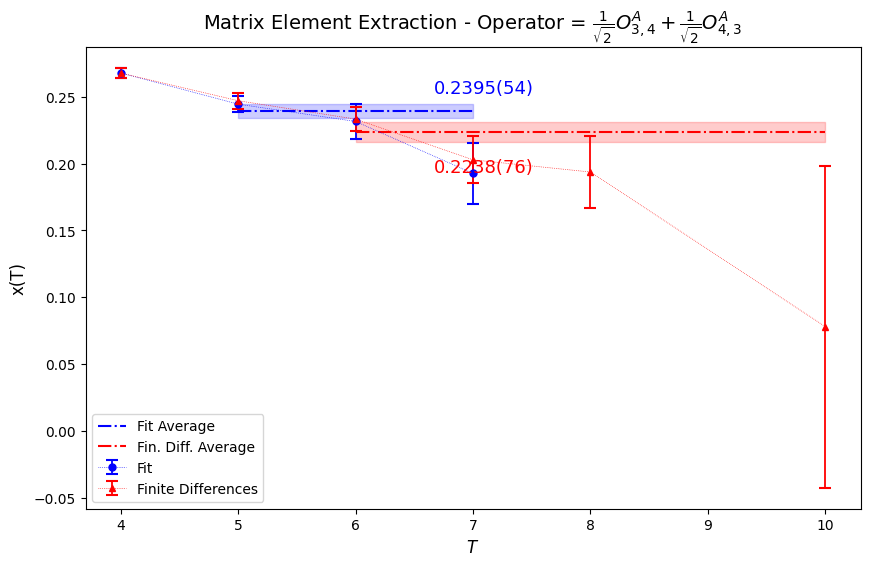

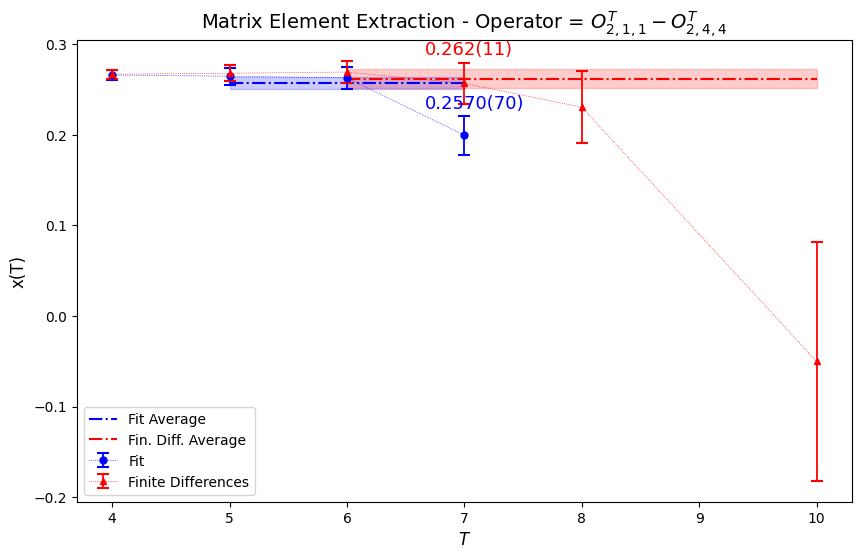

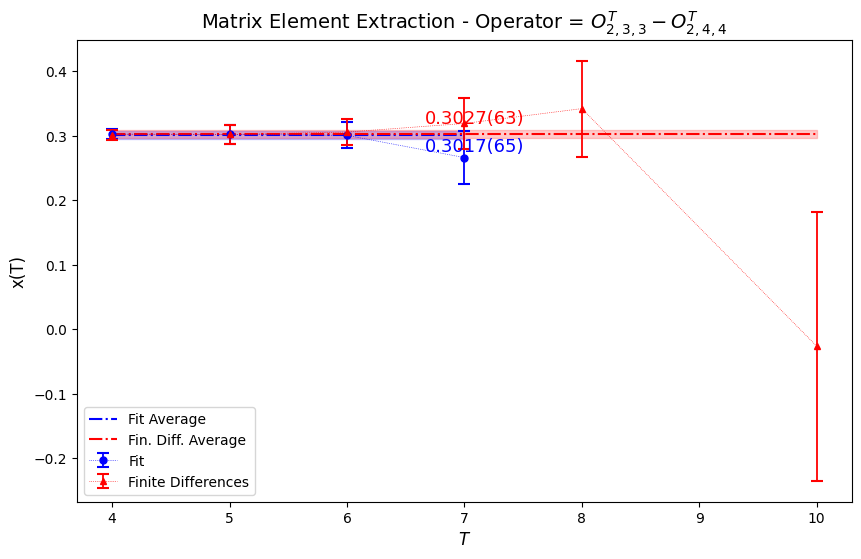

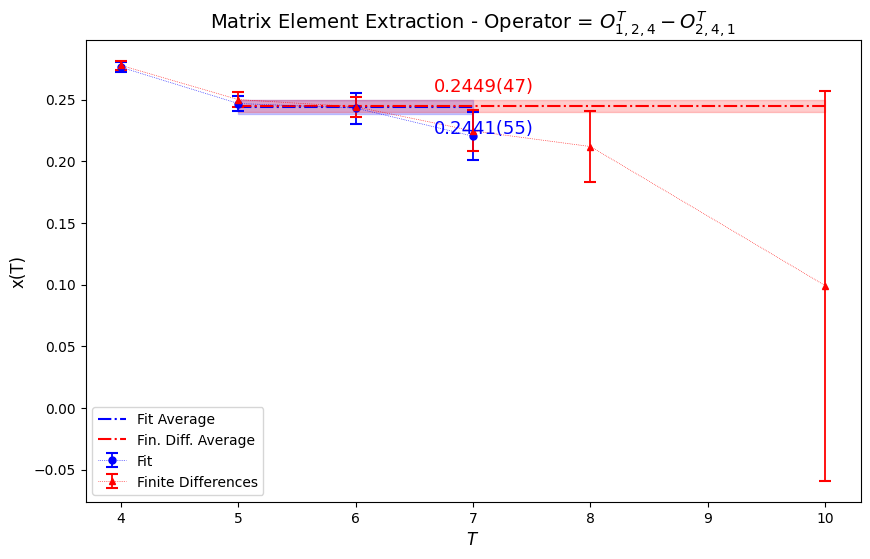

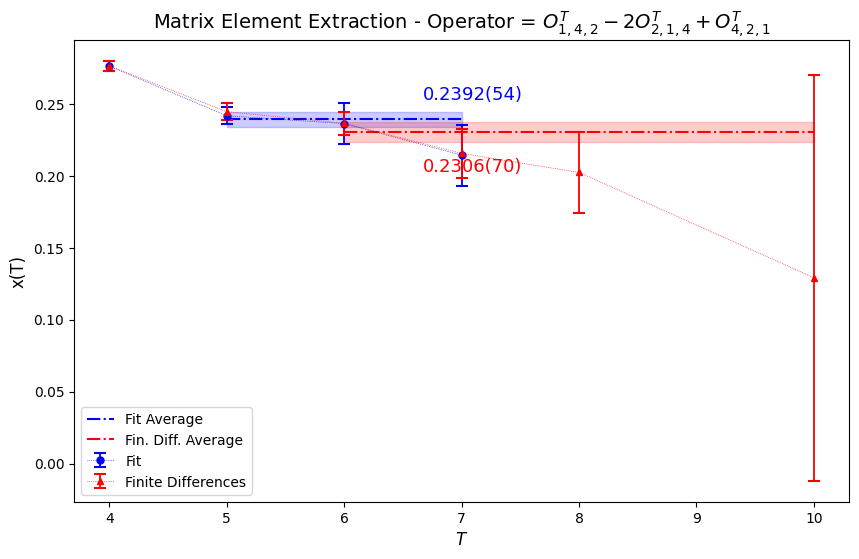

In [38]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    ordinate_array_fit = moments_array_fit if moments else mat_ele_array_fit
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_fit[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 5, linewidth = 0.5,elinewidth=1.3, linestyle='dotted',label=f"Fit",color="blue",  capsize=4.0, capthick=1.5)

    #fit_avg = np.average([ e for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] )
    fit_avg, iTmin = average_moments_over_T(ordinate_array_fit[iop], chi2=1.0)
    _=ax.hlines(fit_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="blue",linestyles="-.", label="Fit Average")
    _=ax.fill_between(asc[iTmin:],fit_avg.mean+fit_avg.sdev,fit_avg.mean-fit_avg.sdev,color="blue",alpha=0.2)


    ordinate_array_diff = moments_array if moments else mat_ele_array
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_diff[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = '^', markersize = 5, linewidth = 0.5, elinewidth=1.3, linestyle='dotted',label=f"Finite Differences",color="red",   capsize=4.0, capthick=1.5)

    #diff_avg = np.average([ e for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] )
    diff_avg, iTmin = average_moments_over_T(ordinate_array_diff[iop], chi2=1.0)
    _=ax.hlines(diff_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="red",linestyles="-.", label="Fin. Diff. Average")
    _=ax.fill_between(asc[iTmin:],diff_avg.mean+diff_avg.sdev,diff_avg.mean-diff_avg.sdev,color="red",alpha=0.2)


    if fit_avg >= diff_avg:
        _=ax.text(np.mean(asc),fit_avg.mean + 2.5*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean - 4.0*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)
    else:
        _=ax.text(np.mean(asc),fit_avg.mean - 4.0*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean + 2.5*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)



    

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

    plt.savefig(f"plots/S_extraction_comparison_iop{iop}.png")


In [39]:
opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.set_fit_parms(central_value_fit=True,central_value_fit_correlated=True,resample_fit=True,resample_fit_correlated=True)


#usage of the new method
moments_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=True)
mat_ele_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=False)
moments_array = opAnalyzer.get_M_from_S(method="finite differences",moments=True)
mat_ele_array = opAnalyzer.get_M_from_S(method="finite differences",moments=False)

opAnalyzer

from moments_toolkit import average_moments_over_T

Instance of the moments_toolkit class

Dataset Specifics:
Number of configurations: 212
P: [-2  0  0]
q: [0 0 0]

Current Selection of Parameters:
Number of Selected Operators: 9
Selected Isospin: U-D
Selected T values: [3, 4, 5, 6, 7, 8, 10, 12]

Fit parameters:
 - Central Value Fit:            True
 - Central Value Fit Correlated: True
 - Resample Fit:                 True
 - Resample Fit Correlated:      True
 - Resample Fit Resample Prior:  False
 - SVD Cut: None
 - Max Iterations: 10000

Resampling Technique: jackknife
Number of resamples: 212

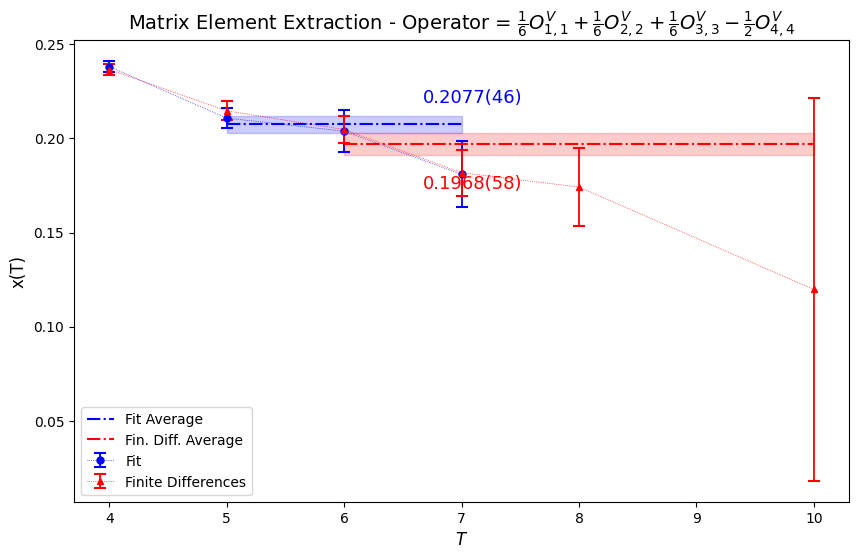

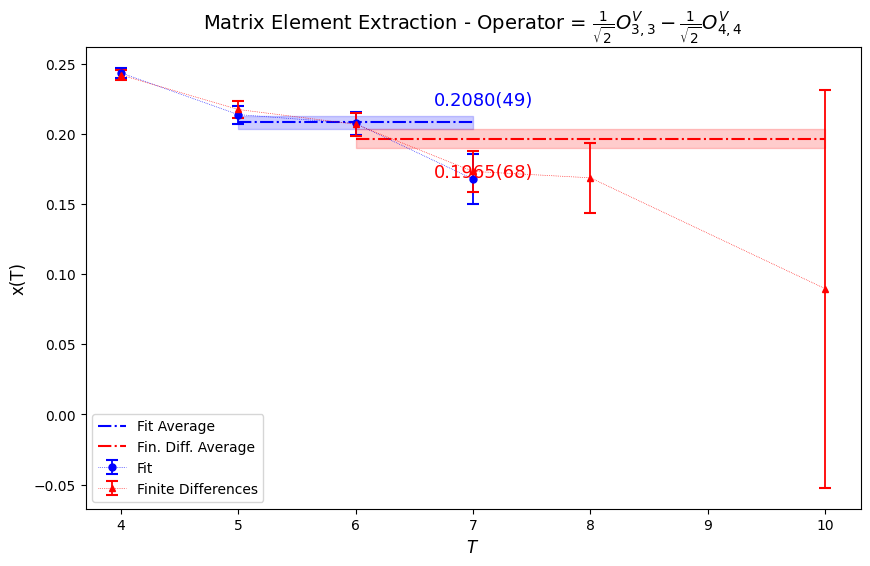

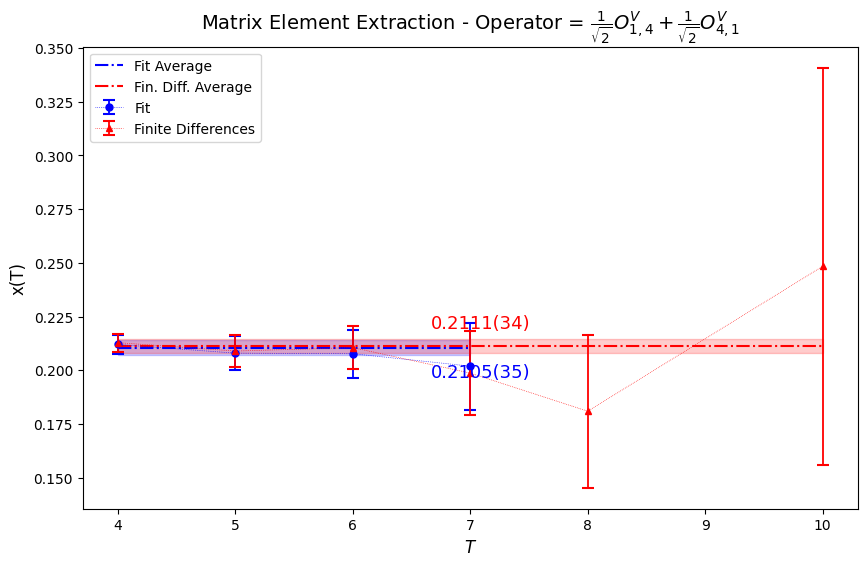

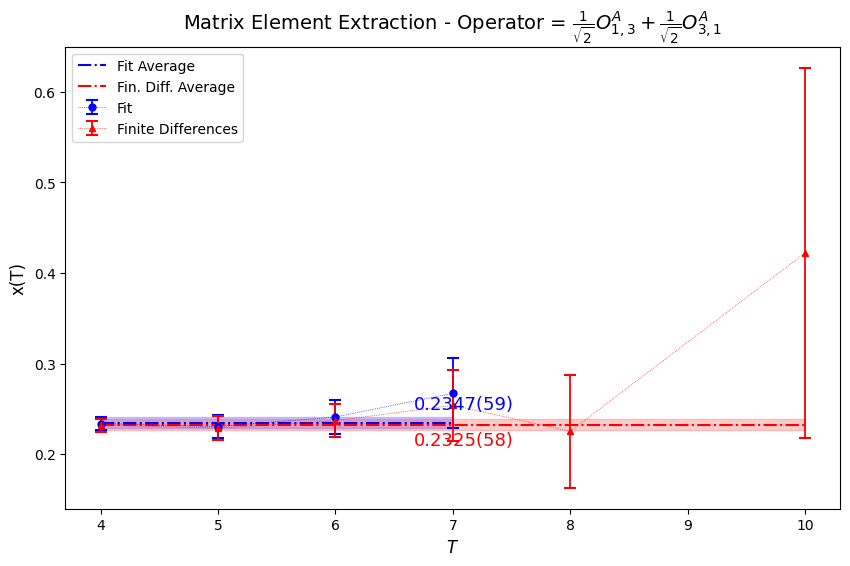

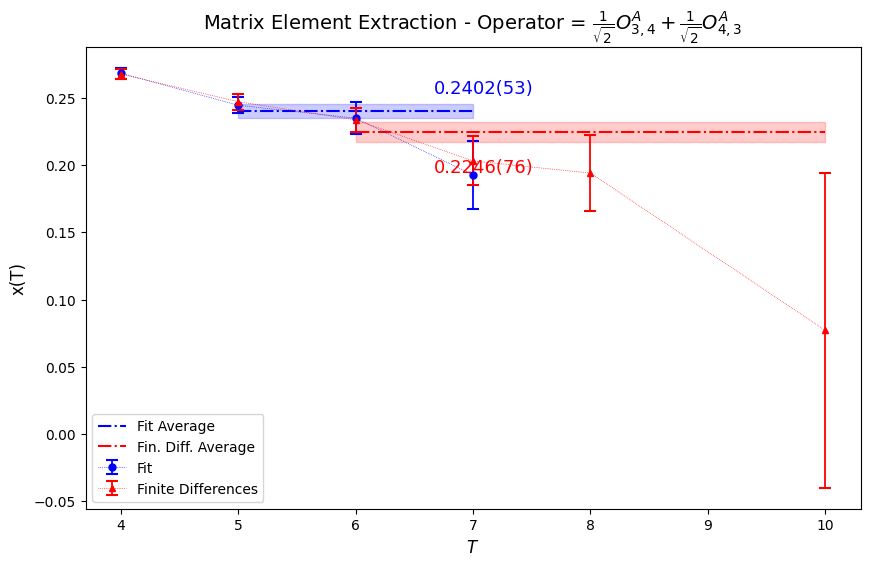

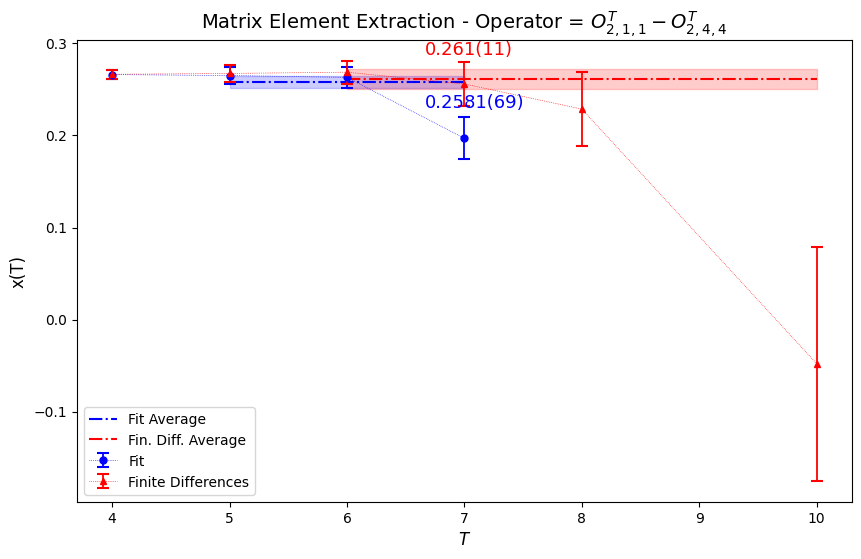

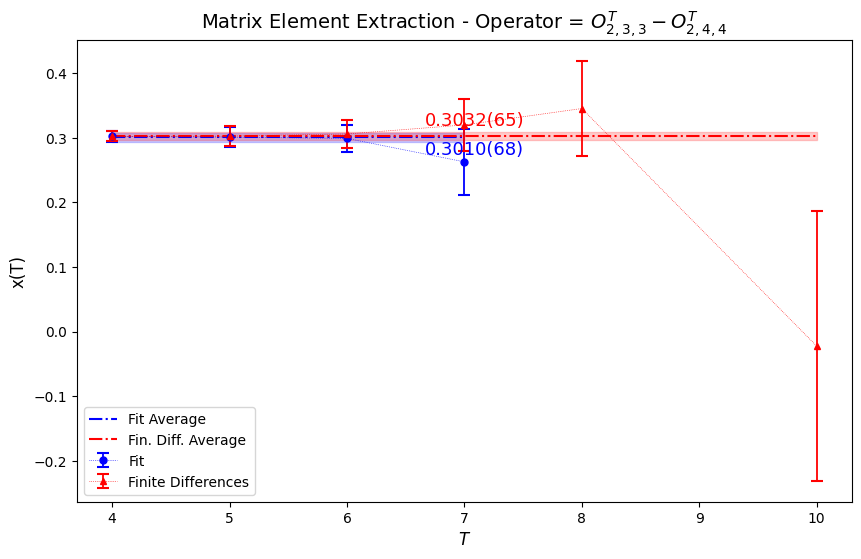

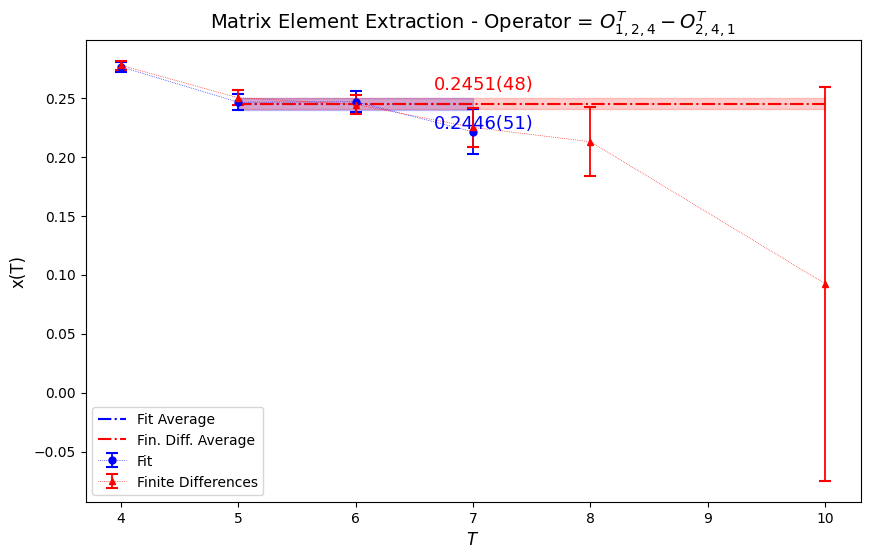

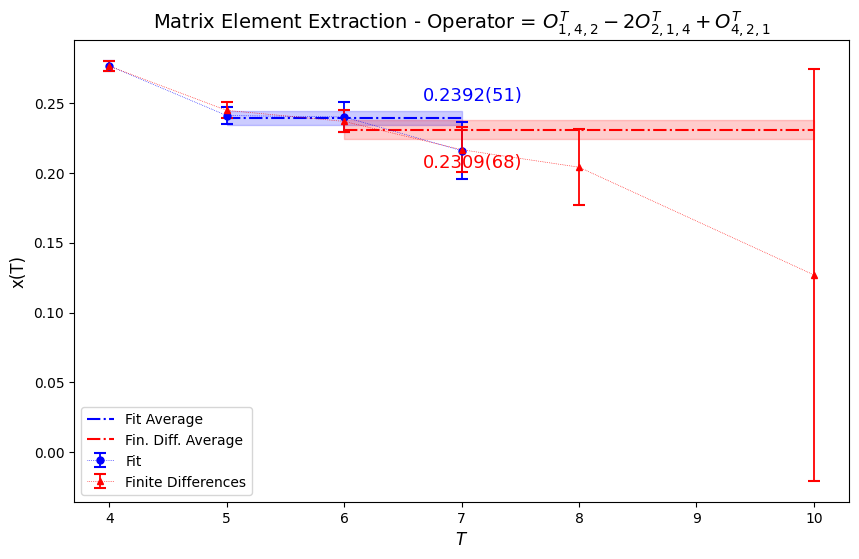

In [40]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    ordinate_array_fit = moments_array_fit if moments else mat_ele_array_fit
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_fit[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 5, linewidth = 0.5,elinewidth=1.3, linestyle='dotted',label=f"Fit",color="blue",  capsize=4.0, capthick=1.5)

    #fit_avg = np.average([ e for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] )
    fit_avg, iTmin = average_moments_over_T(ordinate_array_fit[iop], chi2=1.0)
    _=ax.hlines(fit_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="blue",linestyles="-.", label="Fit Average")
    _=ax.fill_between(asc[iTmin:],fit_avg.mean+fit_avg.sdev,fit_avg.mean-fit_avg.sdev,color="blue",alpha=0.2)


    ordinate_array_diff = moments_array if moments else mat_ele_array
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_diff[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = '^', markersize = 5, linewidth = 0.5, elinewidth=1.3, linestyle='dotted',label=f"Finite Differences",color="red",   capsize=4.0, capthick=1.5)

    #diff_avg = np.average([ e for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] )
    diff_avg, iTmin = average_moments_over_T(ordinate_array_diff[iop], chi2=1.0)
    _=ax.hlines(diff_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="red",linestyles="-.", label="Fin. Diff. Average")
    _=ax.fill_between(asc[iTmin:],diff_avg.mean+diff_avg.sdev,diff_avg.mean-diff_avg.sdev,color="red",alpha=0.2)


    if fit_avg >= diff_avg:
        _=ax.text(np.mean(asc),fit_avg.mean + 2.5*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean - 4.0*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)
    else:
        _=ax.text(np.mean(asc),fit_avg.mean - 4.0*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean + 2.5*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)



    

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

    plt.savefig(f"plots/S_extraction_comparison_iop{iop}.png")